In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [2]:
Sim, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,diff_equation,WENO_Z)
WENO_Z_ref=lambda u0, Δx:DerivadaEspacial(u0,Δx, FronteiraPeriodica)

In [5]:
np.random.seed(seed=8413651)
n=int(100000/2)
k=11
x_rep=20
pesos=np.random.uniform(size=[n,k],low=-10,high=10)
ordem=np.floor(np.random.uniform(size=[n,1],low=0,high=k))+np.asarray([range(k)])
pesos=(1-np.sum(tf.one_hot(ordem,k),axis=1))*pesos

operador_derivada=np.eye(k,k=-1)@np.diag(range(1,k+1))

In [6]:
x=np.expand_dims(np.linspace(-1,1,7*x_rep),axis=0)**np.expand_dims(np.arange(k),axis=1)
Δx=x[1,1]-x[1,0]
Δx_ref=Δx/2
x_ref=(np.reshape(np.linspace(-1,1,7*x_rep),[1,7*x_rep,1])+np.reshape(np.linspace(-1,1,7)*Δx_ref,[1,1,7]))**np.reshape(np.arange(k),[k,1,1])

In [7]:
k1 = np.random.uniform(0, 10, [n,1,1]).astype('int32')   # Amostrando uma frequência aleatória para a função seno
k2 = np.random.uniform(0, 10, [n,1,1]).astype('int32')   # Amostrando uma frequência aleatória para a função seno
a  = np.random.uniform(0, 1, [n,1,1]) # Amostrando um peso aleatória para ponderar as funções seno
b  = np.random.uniform(0, 2, [n,1,1]) # Amostrando um modificador de amplitude aleatório
u1 =     a * tf.math.sin(k1*pi*x[1:2]) # Gerando pontos de acordo com a primeira função seno
u2 = (1-a) * tf.math.sin(k2*pi*x[1:2]) # Gerando pontos de acordo com a segunda função seno

y_sin=(b*(u1+u2))[...,0,:]

u1 =     a * tf.math.sin(k1*pi*x_ref[1:2]) # Gerando pontos de acordo com a primeira função seno
u2 = (1-a) * tf.math.sin(k2*pi*x_ref[1:2]) # Gerando pontos de acordo com a segunda função seno

dy_sin=b*(u1+u2)

y=np.matmul(pesos,x)
y=np.concatenate([y,y_sin],axis=0)

#dy_sin=np.stack(dy_sin,axis=0)
#dy=np.matmul(np.matmul(pesos,operador_derivada),x+Δx/2)
dy=np.matmul(x_ref.T,pesos.T).T
dy=np.concatenate([dy,dy_sin],axis=0)

n=2*n

In [8]:
for l in range(3):
    polis=np.floor(np.random.uniform(size=[n,2],low=0,high=y.shape[0]))
    y0=y[polis[:,0].astype('int32')]
    y1=y[polis[:,1].astype('int32')]
    dy0=dy[polis[:,0].astype('int32')]
    dy1=dy[polis[:,1].astype('int32')]
    position=np.floor(np.random.uniform(size=[n],low=0,high=y.shape[1])).astype('int32')
    cuts=np.random.choice(range(-6,1),size=[n],replace=True,p=[0.25,0.1,0.1,0.1,0.1,0.1,0.25])
    
    for i,j,k in zip(range(n),position,cuts):
        y0[i,j:]=0
        y1[i,:j]=0
        dy0[i,(j+1):]=0
        dy1[i,:j]=0
        
        dy1[i,j,:k]=0
        dy0[i,j,k:]=0
    y=y0+y1
    dy=dy0+dy1

In [9]:
dy=WENO_Z_ref(dy,Δx_ref)[...,3]

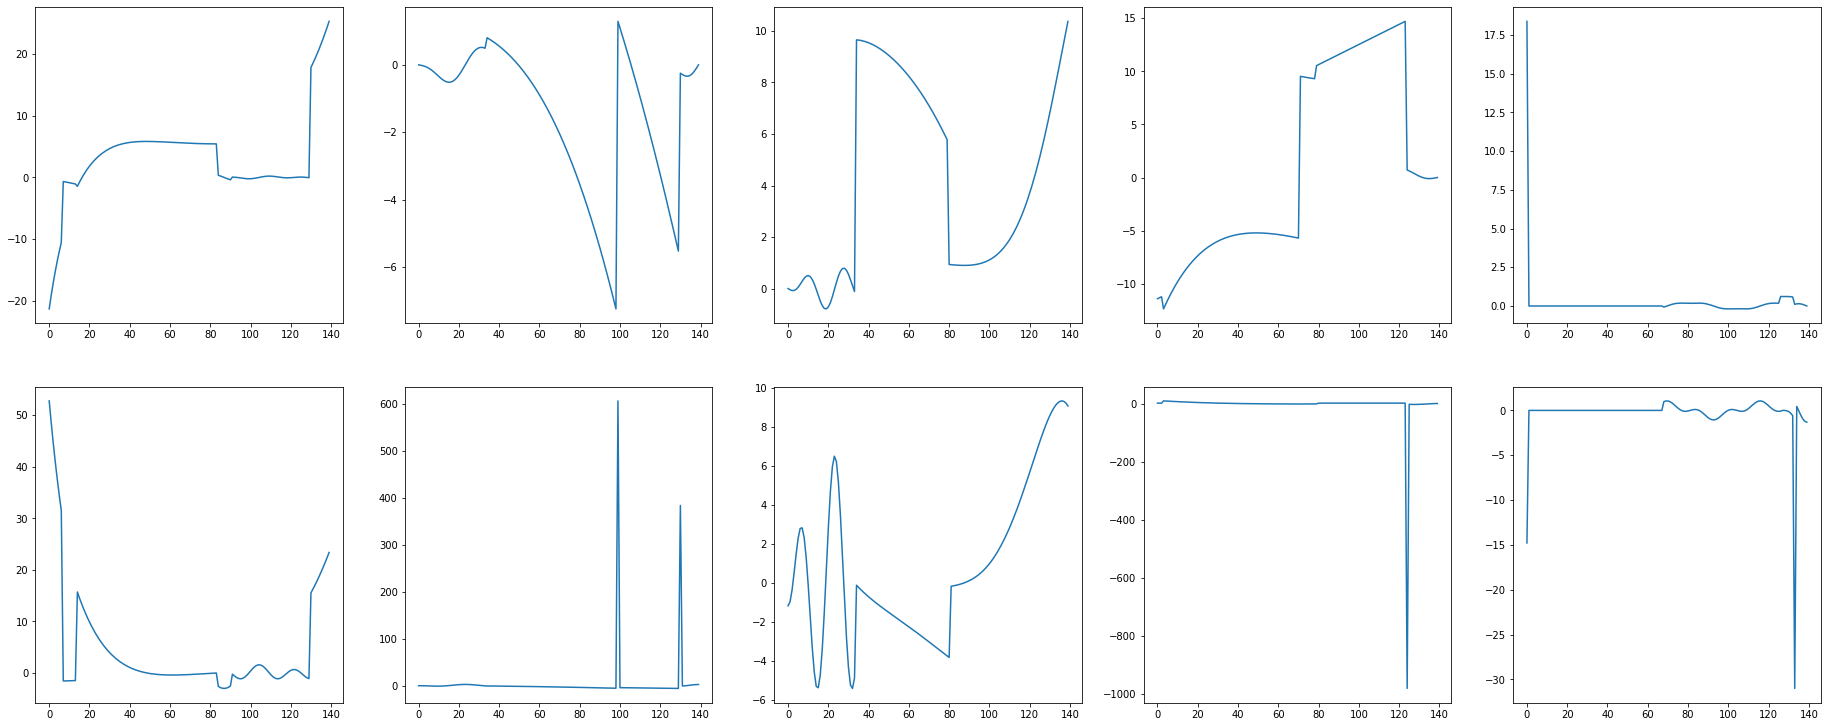

In [10]:
index=np.floor(np.random.uniform(size=[5],low=0,high=n)).astype('int32')

plt.figure(figsize=(6.4*5,6.4*2))
for i,j in zip(range(5),index):
    plt.subplot(2, 5, i+1)
    plt.plot(y[j])
    plt.subplot(2, 5, i+6)
    plt.plot(dy[j])

In [11]:
y = np.concatenate(np.split(y,20,axis=1),axis=0)
dy = dy[:,np.arange(2,120,6)]
dy = np.concatenate(np.split(dy,20,axis=1),axis=0)

In [12]:
indice = np.arange(y.shape[0])
np.random.shuffle(indice)
data_x = y.astype('float64')[indice]
data_y = dy.astype('float64')[indice]

In [13]:
# Conjunto de dados de treino
train_x = data_x[:-20000]
train_y = data_y[:-20000]

# Conjunto de dados de validação
test_x = data_x[-20000:]
test_y = data_y[-20000:]

In [14]:
# Criando uma camada de Burgers que integra o WENO à rede neural
Sim_layer = WENO_espacial(Δx,FronteiraPeriodica)

In [15]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([7], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, Sim_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['MSE'])
# Carregando os pesos da rede neural treinados
#Network.load_weights('Modelo artigo')

In [ ]:
# Treinando a rede neural
Network.fit(
    train_x                           , # Dados de treino
    train_y                           , # Dados de treino
    validation_data = (test_x, test_y), # Dados de validação
    batch_size      = 1024            , # Tamanho do batch
    epochs          = 100             , # Número de epochs
    steps_per_epoch = 300             , # Número de batchs por epoch
    shuffle         = True              # Aleatorização dos batchs
)

# Batch: pacote de dados utilizados antes de uma atualização dos pesos da rede
# Epoch: rodada de treino da rede neural, em geral percorre todo o conjunto de dados

In [23]:
# Salvando os pesos treinados
Network.save_weights('Modelos treinados\\Modelo Rede para derivada corrigido 3')

In [18]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados\\Modelo Rede para derivada corrigido 3')

In [17]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([200], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, final_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='MSE', optimizer=optimizer, metrics=['mean_absolute_error'])

In [18]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa
Δx_ref = 0.01
Δx = Δx_ref                                # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
                             # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: -(-tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres)))

full_U=tf.expand_dims(f_test(x),axis=0)

net_u   = Network(full_U)

In [19]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa

k=1

Δx = Δx_ref/k                              # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
                             # Distância espacial dos pontos na malha utilizada
# Condição inicial do artigo do WENO-Z

full_U=tf.expand_dims(f_test(x),axis=0)

debug_u   = WENO_Z_ref(full_U,Δx)         # Previsão com o WENO-Z modificado pela rede neural

In [20]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa

k=4

Δx = Δx_ref/k                               # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
                             # Distância espacial dos pontos na malha utilizada

full_U=tf.expand_dims(f_test(x),axis=0)

ref_full   = tf.gather(WENO_Z_ref(full_U,Δx),np.arange(net_u.shape[-1])*k,axis=-1)             # Previsão com o WENO-Z modificado pela rede neural

# Armazenando ambos os erros de previsão
error = tf.stack([net_u-ref_full,debug_u-ref_full],axis=0)
error = tf.squeeze(error)

In [21]:
# Calculando média dos erros de acordo com a norma L2, L1 ou L-inf

# Norma L2:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_sum(error**2, axis=-1)**0.5
#--------------------------------------------------------------------------------------
print('L2:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Norma L1:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_sum(tf.abs(error), axis=-1)
#--------------------------------------------------------------------------------------
print('L1:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Noma L-inf:
#-------------------------------------------------------------------------------------
desv_error = tf.math.reduce_max(tf.abs(error), axis=-1)
#--------------------------------------------------------------------------------------
print('L-inf:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())

L2:
[198.5629938  158.11396846]
1.255821960148529


L1:
[521.92986267 200.01318739]
2.609477252442114


L-inf:
[196.83178476 150.00013951]
1.3122106780127019


In [109]:
Sim, DerivadaEspacial=create_simulation(API_Numpy,diff_equation)
WENO_Z_ref=lambda u0, Δx:DerivadaEspacial(u0,Δx, FronteiraPeriodica)

In [78]:
Δx_ref = 0.01

def f(x):
    return np.sin(np.pi*x)

def df(x):
    return np.pi*np.cos(np.pi*x)


In [84]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([200], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, final_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='MSE', optimizer=optimizer, metrics=['mean_absolute_error'])

In [85]:
Δx1 = Δx_ref
x1  = np.arange(-1, 1, Δx1)
x1  = np.expand_dims(x1,0)
u1  = f(x1)
du1 = df(x1)
y1=Network(u1, Δx1)

print(u1.shape)

(1, 200)


In [86]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([400], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, final_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='MSE', optimizer=optimizer, metrics=['mean_absolute_error'])

In [87]:
Δx2 = Δx_ref/2
x2  = np.arange(-1, 1, Δx2)
x2  = np.expand_dims(x2,0)
u2  = f(x2)
du2 = df(x2)
y2=Network(u2, Δx2)

print(u2.shape)

(1, 400)


In [88]:
# Gerando os gráficos a partir de funções do matplotlib

print(np.sum(abs(y1 - du1))/np.sum(abs(y2 - du2)))

# print(np.mean(abs(WENO_Z_ref(u1, Δx1) - df(x1 + Δx1/2)))/np.mean(abs(WENO_Z_ref(u2, Δx2) - df(x2 + Δx2/2))))

# fig = plt.figure(1, constrained_layout=True,figsize=(6,6))
# ax  = fig.add_subplot(1,1,1);
# # ax.set_ylim(-2, 2);
# # ax.set_xlim(0,1);
# line = ax.plot(x1, WENO_Z_ref(u1, Δx1) - du1)
# # line = ax.plot(x1, du1)
# line = ax.plot(x2, WENO_Z_ref(u2, Δx2) - du2)
# # line = ax.plot(x2, du2)
# hfig = display(fig, display_id=True)


31.797876452209383
